# Quadtree decomposition with <i>kite</i>

The <i><a href="https://pyocko.org">pyrocko</a></i> suite of tools comprise a series of open source applications designed to simplify the modeling of earthquakes, using both seismic and InSAR data. Here we will use one of those applications, <i>kite</i>, to read in and downsample an ISCE interferogram using quadtree decomposition.

## Setup

First, install some dependencies (if you haven't already)...

In [2]:
# ignore if you already have these installed!
!pip install pyrocko
!pip install utm
!pip install git+https://github.com/pyrocko/kite

/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found


...and import the necessary dependencies: 

In [21]:
import numpy as np
from kite import Scene
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import math
from osgeo import gdal

We will use, for this exercise, a pre-processed interferogram of the Elazig earthquake in Turkey. Let's grab it (and some other key files) off of the cloud! (This workflow should work for any ISCE-processed interferogram though.)

In [ ]:
!aws s3 cp s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo .
!aws s3 cp s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo.vrt .
!aws s3 cp s3://asf-jupyter-data/Elazig/filt_topophase.unw.geo.xml .
!aws s3 cp s3://asf-jupyter-data/Elazig/los.rdr.geo .
!aws s3 cp s3://asf-jupyter-data/Elazig/los.rdr.geo.vrt .
!aws s3 cp s3://asf-jupyter-data/Elazig/los.rdr.geo.xml .
!aws s3 cp s3://asf-jupyter-data/Elazig/water.msk .
!aws s3 cp s3://asf-jupyter-data/Elazig/water.msk.vrt .
!aws s3 cp s3://asf-jupyter-data/Elazig/water.msk.xml .
!aws s3 cp s3://asf-jupyter-data/Elazig/topophase.cor.geo .
!aws s3 cp s3://asf-jupyter-data/Elazig/topophase.cor.geo.vrt .
!aws s3 cp s3://asf-jupyter-data/Elazig/topophase.cor.geo.xml .

Next, we specify a path and some filenames:

In [22]:
ifgpath="/mnt/f/work/quakes/elazig/merged/" # directory with your interferogram
ifgname="filt_topophase.unw.geo"                                      # interferogram file
corname="topophase.cor.geo"                                           # correlation file
mskname="water.msk"                                                   # water mask file

Here are a couple of important parameters. <i>kite</i> currently cannot read in the radar wavelength from the interferogram metadata, as it is not included in the xml file(!) and so we specify it here. We also supply a correlation threshold for masking out low correlation data points.

In [23]:
wavel = 0.0555     # radar wavelength in m
cor_thresh = 0.2  # correlation threshold between 0 (bad) and 1 (perfect)

In [22]:
!ls /mnt/c/Users/garet/

'Chrome Remote Desktop.lnk'  "Sid Meier's Civilization V.url"
'Cisco Webex Meetings.lnk'   'The Witness.url'
'Docker Desktop.lnk'	     'XCOM 2.url'
 Dropbox.lnk		      XLaunch.xlaunch
'Football Manager 2018.url'   Zoom.lnk
 Insomnia.exe		      balenaEtcher.lnk
'Microsoft Teams.lnk'	      debug.log
'Portal 2.url'		      desktop.ini


## Load in the interferogram

It is  a single command to read in an interferogram with <i>kite:</i>

In [24]:
sc = Scene.import_data(ifgpath+ifgname)

We can look and see what we imported using a few matplotlib commands

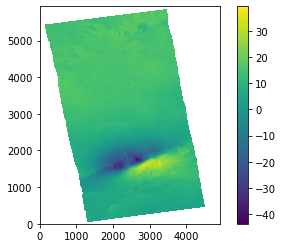

In [25]:
#matplotlib inline
fig, ax1 = plt.subplots()                       # new figure called "ax1"
im = ax1.imshow(sc.displacement,origin='lower') # plot displacements with origin at lower left (kite default)
fig.colorbar(im)                                # plot a color bar!
plt.show();

## Masking and unit conversion

A freshly unwrapped and loaded interferogram will not have been masked for 'bad' (low correlation) data points, or for water. If we include these in our downsampled data, we will be corrupting our data with errors. We can use a combination of gdal and numpy to load in the correlation and water mask files, and replace them with NaNs (which is how <i>kite</i> treats null data). First, load them in:

In [26]:
# correlation file
corfile=gdal.Open(ifgpath+corname,gdal.GA_ReadOnly)   # open with gdal
rb = corfile.GetRasterBand(2)                         # correlation info is in band 2
cor = rb.ReadAsArray()                                # read it in as a number array
cor=np.flip(cor,0)                                    # flip image to account for origin position
                                                      # (kite prefers lower left; ISCE, top left)

# water mask file
mskfile=gdal.Open(ifgpath+mskname,gdal.GA_ReadOnly)  
rb = mskfile.GetRasterBand(1)                         # only one band here
msk = rb.ReadAsArray()
msk=np.flip(msk,0)

We can convert the interferogram from radians to meters (ISCE does not include wavelength information in the interferogram metadata files, so it is not applied automatically by <i>kite</i>):

In [27]:
sc.displacement*=wavel/4/math.pi   # change values of sc.displacement in place

Next, replace the zeros in the water mask, and values with low correlation, by NaNs:

In [28]:
sc.displacement[msk<1]=np.nan
sc.displacement[cor<cor_thresh]=np.nan

And plot to see if it worked!

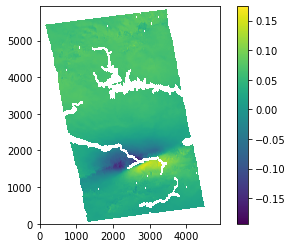

In [29]:
#matplotlib inline
fig, ax2 = plt.subplots()
im = ax2.imshow(sc.displacement,origin='lower')
cb=fig.colorbar(im)

## Quadtree decomposition

We can initialize the quadtree decomposition in <i>kite</i> by defining an abbreviation:

In [30]:
qt = sc.quadtree

And we can specify some parameters that control the quadtree process:

In [31]:
qt.epsilon = 0.02         # Variance threshold
qt.nan_allowed = 0.5      # Percentage of NaN values allowed per tile/leaf
qt.tile_size_max = 0.2    # Maximum leaf size in degrees
qt.tile_size_min = 0.01  # Minimum leaf size in degrees

Let's look at the distribution of leaves/tiles. Typically we are looking for a few hundred... If you don't like what you have, try editing the values above and re-running. If you would like more leaves, lower the epsilon value and/or make the tile sizes smaller. If you want fewer, do the opposite!

In [32]:
print("There are",qt.nleaves,"leaves")

There are 194 leaves


And if you want to see the quadtree results, you can. This example prints out the leaf number, the lower left ('ll') east and north coordinates of the leaf (with respect to the lower left of the whole image), and the mean displacement of the pixels in that leaf:

In [13]:
j=0
for k in qt.leaves:
    print("leaf",j,"llE:",qt.leaves[j].llE,"llN:",qt.leaves[j].llN,"mean:",qt.leaves[j].mean) 
    j=j+1

leaf 0 llE: 0.28444444444444444 llN: 0.0 mean: 0.02218102291226387
leaf 1 llE: 0.42666666666666664 llN: 0.0 mean: 0.02748042903840542
leaf 2 llE: 0.28444444444444444 llN: 0.14222222222222222 mean: 0.018053289502859116
leaf 3 llE: 0.42666666666666664 llN: 0.14222222222222222 mean: 0.024616478011012077
leaf 4 llE: 0.28444444444444444 llN: 0.28444444444444444 mean: 0.0051778219640254974
leaf 5 llE: 0.42666666666666664 llN: 0.28444444444444444 mean: -0.0013410821557044983
leaf 6 llE: 0.49777777777777776 llN: 0.28444444444444444 mean: 0.014466454274952412
leaf 7 llE: 0.42666666666666664 llN: 0.35555555555555557 mean: -0.04388043284416199
leaf 8 llE: 0.49777777777777776 llN: 0.35555555555555557 mean: -0.031142612919211388
leaf 9 llE: 0.5333333333333333 llN: 0.35555555555555557 mean: -0.019946299493312836
leaf 10 llE: 0.49777777777777776 llN: 0.39111111111111113 mean: -0.08193103969097137
leaf 11 llE: 0.5333333333333333 llN: 0.39111111111111113 mean: -0.06455549597740173
leaf 12 llE: 0.551111

leaf 146 llE: 0.14222222222222222 llN: 0.8533333333333333 mean: 0.06913089752197266
leaf 147 llE: 0.14222222222222222 llN: 0.9955555555555555 mean: 0.07301772385835648
leaf 148 llE: 0.28444444444444444 llN: 0.8533333333333333 mean: 0.0675099715590477
leaf 149 llE: 0.42666666666666664 llN: 0.8533333333333333 mean: 0.06251417845487595
leaf 150 llE: 0.28444444444444444 llN: 0.9955555555555555 mean: 0.06764136254787445
leaf 151 llE: 0.42666666666666664 llN: 0.9955555555555555 mean: 0.06574688106775284
leaf 152 llE: 0.5688888888888889 llN: 0.5688888888888889 mean: -0.011477554216980934
leaf 153 llE: 0.64 llN: 0.5688888888888889 mean: -0.017618488520383835
leaf 154 llE: 0.5688888888888889 llN: 0.64 mean: 0.026298578828573227
leaf 155 llE: 0.64 llN: 0.64 mean: 0.022877510637044907
leaf 156 llE: 0.7111111111111111 llN: 0.5688888888888889 mean: -0.01767834462225437
leaf 157 llE: 0.7822222222222223 llN: 0.5688888888888889 mean: -0.024610262364149094
leaf 158 llE: 0.7111111111111111 llN: 0.64 mea

And you can plot them too!

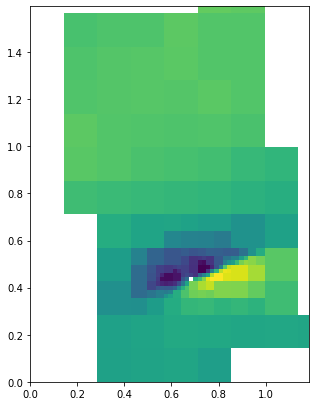

In [32]:
#matplotlib inline
fig, ax3 = plt.subplots(figsize=[5,7.5])

ulimit = qt.leaf_medians.max()
llimit = qt.leaf_medians.min()

color_map = cm.ScalarMappable(
    norm=colors.Normalize(vmin=llimit, vmax=ulimit))

for rect, leaf in zip(qt.getMPLRectangles(), qt.leaves):
    color = color_map.to_rgba(leaf.median)
    rect.set_facecolor(color)
    ax3.add_artist(rect)


ax3.set_xlim(0, qt.leaf_eastings.max())
ax3.set_ylim(0, qt.leaf_northings.max())
ax3.set_aspect('equal')


plt.show();

array(<kite.quadtree.QuadNode object at 0x7f96e3bcb730>, dtype=object)

## Saving the output

This last section saves your files, both in <i>kite</i>'s internal format, and in a comma-separated variable file:

In [33]:
sc.save('elazig_asc_kite_scene')
#qt.export('elazig_asc_quadtree.csv')